# **1. PERKENALAN**

> Nama       : Al Izhar Iqrami

> Batch      : 011 Data Science Hacktive8

> Phase      : 1

> Pembahasan : GC2

> Query mendapatkan dataset pada google cloud : 

>>select age, workclass, education, education_num, marital_status, occupation, relationship, race, sex, capital_gain, capital_loss, hours_per_week, native_country, income_bracket

>>from `bigquery-public-data.ml_datasets.census_adult_income` 

>>where not workclass like '%?' and hours_per_week < 100

>>limit 21989

# **2. IMPORT LIBRARY**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import ast


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error, r2_score
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay,confusion_matrix,recall_score

>*Pada tahap ini kami melakuakn import library yang berguna untuk membatu memecahkan permasalahan yang diperolah pada saat melakuakan analisis data*

# **3. DATA LOADING**

In [2]:
pd.options.display.max_columns = None
df = pd.read_csv('dataset.csv')
df.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,Private,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,3411,0,34,United-States,<=50K
1,72,Private,9th,5,Married-civ-spouse,Exec-managerial,Wife,Asian-Pac-Islander,Female,0,0,48,United-States,>50K
2,45,Private,9th,5,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,0,0,40,United-States,>50K
3,31,Private,9th,5,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
4,55,Private,9th,5,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,23,United-States,<=50K


>*Melakukan load terhadap dataset serta menampilkan 5 baris pertama dan 5 baris terakhir sesuai instruksi soal*

**Duplicate Dataset**

In [3]:
data = df.copy()
data.shape

(21989, 14)

>*Menduplicate data original agar supaya jika terdapat kesalahan pada proses pengolahan data kami dapat dengan mudah memperoleh data original.Terlihat bahwa kami memiliki 21989 baris dan 14 kolom*

**Drop Duplicate**

In [4]:
data = data.drop_duplicates(keep= 'last')
data.shape

(19356, 14)

>*Menghapus baris data yang datanya terdapat kesamaan untuk seluruh elemenya ditiap kolom-nya, serta memperbaharui index-nya dengan bantuan keep. Terlihat bahwa jumlah baris data telah berkurang sebanyak 2633 baris.*

**Check Dataset**

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19356 entries, 0 to 21988
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             19356 non-null  int64 
 1   workclass       19356 non-null  object
 2   education       19356 non-null  object
 3   education_num   19356 non-null  int64 
 4   marital_status  19356 non-null  object
 5   occupation      19356 non-null  object
 6   relationship    19356 non-null  object
 7   race            19356 non-null  object
 8   sex             19356 non-null  object
 9   capital_gain    19356 non-null  int64 
 10  capital_loss    19356 non-null  int64 
 11  hours_per_week  19356 non-null  int64 
 12  native_country  19356 non-null  object
 13  income_bracket  19356 non-null  object
dtypes: int64(5), object(9)
memory usage: 2.2+ MB


>*Terlihat bahwa terdapat 21989 baris dan jumlah kolom 14 kolom. Diantaranya ialah 5 kolom bertipe integer, dan 9 kolom kolom bertipe object.*

**Cek Missing Value**

In [6]:
cek = pd.DataFrame(data.isnull().sum(), columns=['Missing values'])
cek['Persentase Missing Value'] = (cek/len(data)).round(2)*100
cek

,Missing values,Persentase Missing Value
age,0,0.0
workclass,0,0.0
education,0,0.0
education_num,0,0.0
marital_status,0,0.0
occupation,0,0.0
relationship,0,0.0
race,0,0.0
sex,0,0.0
capital_gain,0,0.0


>*Setelah melakukan eksplorasi terhadap data, saya menemukan bahwa terdapat data kosong namun tidak dianggap missing value. Data kosong ini berisikan input `?` dan terletak pada kolom `occupation` sebanyak `6 data` dan kolom `native_country` sebanyak `388 data`. Saya lebih memilik untuk membiarkan kolom tersebut berisikan `?`. Karena jika dilakukan drop maka kita akan kehilangan banyak informasi, dan jika di isi dengan input `modus` maka kita telah mengubah informasi data tersebut. Misalnya `native_country` (negara asal) memiliki modus `United-States`. dan kita ubah `?` dengan nilai modus tersebut, maka secara tidak langsung kita telah mengubah informasi pada baris tersebut.*

# **4. EXPLORATORY DATA ANALYSIS (EDA)**

>**Visualisasi Target Income Bracket**

<AxesSubplot:>

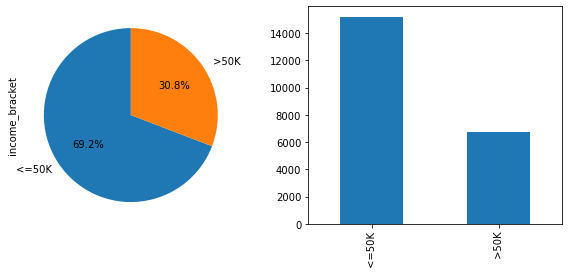

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
df['income_bracket'].value_counts().plot.pie(autopct='%1.1f%%', startangle = 90, ax=axs[0])
df['income_bracket'].value_counts().plot(kind='bar', ax=axs[1])

>> Terdapay imbalance yang cukup besar berdasarkan kolom `income_bracker`, terlihat bahwa golongan pendapatan kurang dari `50K` lebih banyak dibandingkan yang memiliki pendapatan lebih dari `50K`.

**Income Bracket vs Age**

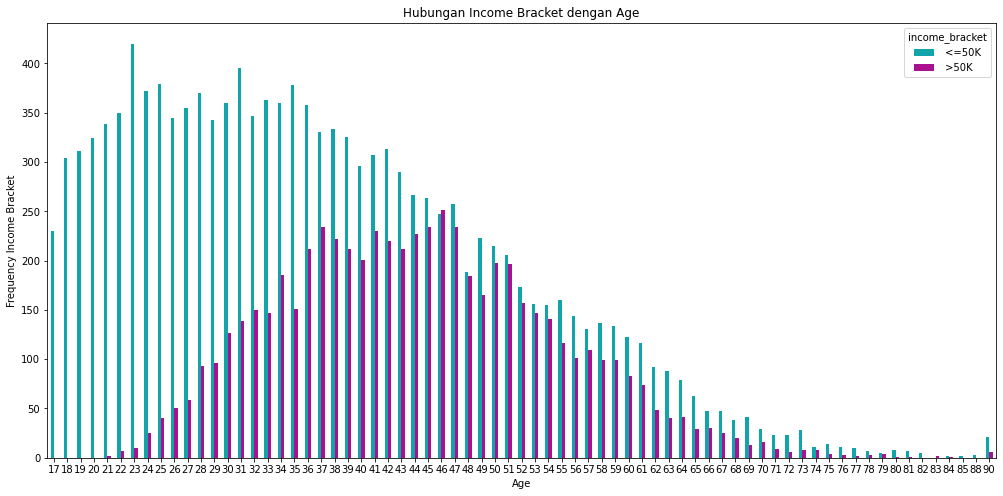

In [8]:
pd.crosstab(data.age, data.income_bracket).plot(kind="bar",figsize=(17,8),color=['#11A5AA','#AA1190'])
plt.title('Hubungan Income Bracket dengan Age')
plt.xlabel('Age')
plt.xticks(rotation = 0)
plt.ylabel('Frequency Income Bracket')
plt.show()

> Berdasatkan rentang usia terlihat bahwa : 

> - Seseorang yang mendapatkan `income bracket >50K terbanyak pada usia 46 tahun`
> - Seseorang yang mendapatkan `income bracket <50K terbanyak terletak pada usia 23 tahun`
> - Seseorang yang memiliki usia `21 tahun kebawah tidak memiliki income_bracket >50K`

**Income Bracket vs Marital Status**

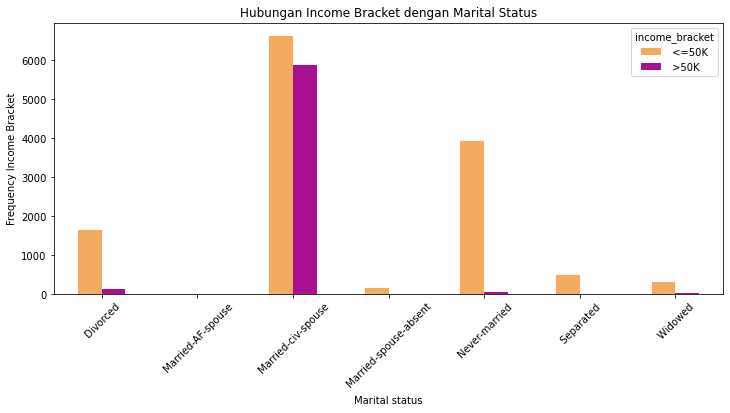

In [9]:
pd.crosstab(data.marital_status, data.income_bracket).plot(kind="bar",figsize=(12,5),color=["#F3AB60",'#AA1190'])
plt.title('Hubungan Income Bracket dengan Marital Status')
plt.xlabel('Marital status')
plt.xticks(rotation = 45)
plt.ylabel('Frequency Income Bracket')
plt.show()

> Berdasarkan status pernikahan, terlihat yang memiliki status telah menikah lebih banyak memiliki `income bracket <=50K dan juga >50K` dibandingkan dengan status yang lain.

**Income Bracket vs Occupation**

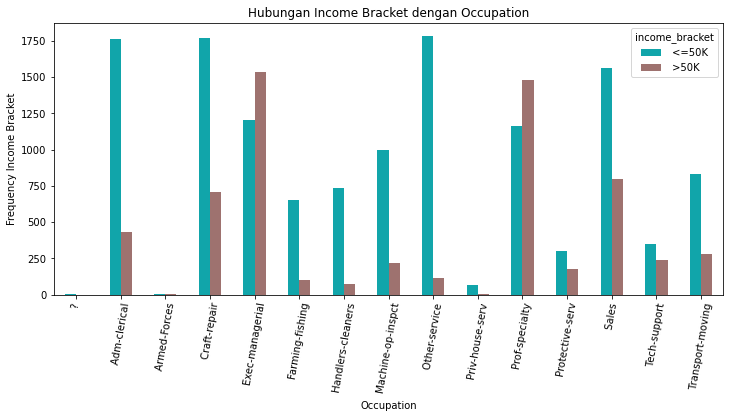

In [10]:
pd.crosstab(data.occupation, data.income_bracket).plot(kind="bar",figsize=(12,5),color=['#11A5AA',"#9E726F"])
plt.title('Hubungan Income Bracket dengan Occupation')
plt.xlabel('Occupation')
plt.xticks(rotation = 80)
plt.ylabel('Frequency Income Bracket')
plt.show()

> Berdasarkan pekerjaan, terlihat bahwa `Armed_forces` adalah pekerjaan dengan proporsi paling rendah berdasarkan `income_bracket` dibandingkan dengan jenis pekerjaan yang lain.

**Income Bracket vs Relationship**

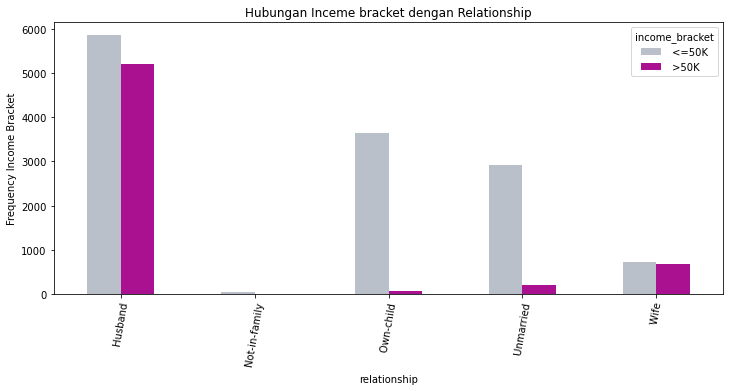

In [11]:
pd.crosstab(data.relationship, data.income_bracket).plot(kind="bar",figsize=(12,5),color=["#B9C0C9",'#AA1190'])
plt.title('Hubungan Inceme bracket dengan Relationship')
plt.xlabel('relationship')
plt.xticks(rotation = 80)
plt.ylabel('Frequency Income Bracket')
plt.show()

> Berdasarkan relationship, terlihat bahwa `husband(suami)` memiliki pendapatan yang lebih banyak dibandingkan hubungan yang lian

**Income Bracket vs Gender**

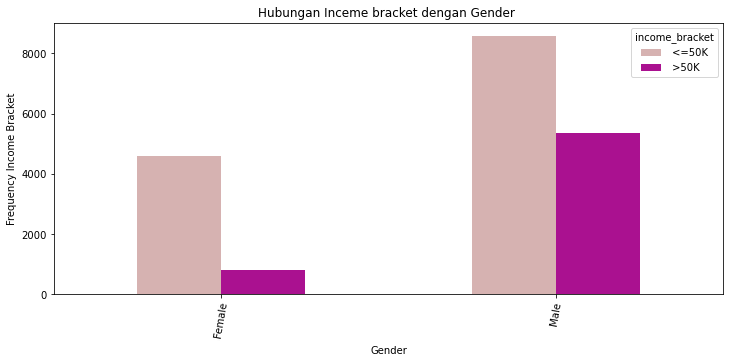

In [12]:
pd.crosstab(data.sex, data.income_bracket).plot(kind="bar",figsize=(12,5),color=["#D6B2B1",'#AA1190'])
plt.title('Hubungan Inceme bracket dengan Gender ')
plt.xlabel('Gender')
plt.xticks(rotation = 80)
plt.ylabel('Frequency Income Bracket')
plt.show()

> Berdasarkan gender terlihat bahwa `pria` memiliki pendapatan lebih banyak pendapatan dibandingkan `wanita`. grafik ini mendukung pendapat kita sebelumnya dimana suami memiliki pendapatan yang lebih dibandingkan istri

## **5. DATA PREPROCESSING**

**DATA INFERENCE**

In [13]:
data_inf = data.sample(10, random_state=5)

**PISAHKAN DATA INFERENCE DARI DATA SET**

In [14]:
data_train_test = data.drop(data_inf.index)

**RESET INDEKS (Optional)**

In [15]:
data_inf.reset_index(drop=True, inplace=True)
data_train_test.reset_index(drop=True, inplace=True)

**SPLIT DATASET**

> Split `X` (features) dan `y` (target)

In [16]:
X = data.drop('income_bracket', axis=1)
y = data.income_bracket

> Split `train-set` dan `test-set`

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)   # (nilai random_state ini tidak memiliki hubungan dengan random_state di awal)

print("X_train shape:",X_train.shape)
print("X_test shape :",X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)


X_train shape: (15484, 13)
X_test shape : (3872, 13)
y_train shape: (15484,)
y_test shape: (3872,)


**HANDLING OUTLIER**

>X_train

In [18]:
num_train = X_train._get_numeric_data() 
for k, v in num_train.items():
  q1 = v.quantile(0.25)
  q3 = v.quantile(0.75)
  irq = q3 - q1
  v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
  perc = np.shape(v_col)[0] * 100.0 / np.shape(num_train)[0]
  print("Column %s outliers = %.2f%%" % (k, perc))

Column age outliers = 0.49%
Column education_num outliers = 1.58%
Column capital_gain outliers = 100.00%
Column capital_loss outliers = 100.00%
Column hours_per_week outliers = 28.22%


>*Cek Jenis Outlier*

>> *Kolom yang memiliki outlier dibawah 5% akan saya handling dengan trimming, serta untuk kolom yang nilai outliernya lebih dari 5% maka akan dilakukan handling dengan cara capping (tentunya dengan pengecekan jenis outlier terlebih dahulu).*

> Trimming

In [19]:
# Function to find upper and lower boundaries for skewed distributed variables
# Let's calculate the boundaries outside which sit the outliers for skewed distributions
# Distance passed as an argument, gives us the option to estimate 1.5 times or 3 times the IQR to calculate the boundaries.

def find_skewed_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [20]:
# Limits for `Age`
age_upper_limit, age_lower_limit = find_skewed_boundaries(X_test, 'age', 1.5)
age_upper_limit, age_lower_limit

print('age_upper_limit : ', age_upper_limit)
print('age_lower_limit : ', age_lower_limit, '\n')

# Limits for `education_num`
education_num_upper_limit, education_num_lower_limit = find_skewed_boundaries(X_test, 'education_num', 1.5)
education_num_upper_limit, education_num_lower_limit

print('education_num_upper_limit : ', education_num_upper_limit)
print('education_num_lower_limit : ', education_num_lower_limit)

age_upper_limit :  77.5
age_lower_limit :  1.5 

education_num_upper_limit :  16.5
education_num_lower_limit :  4.5


In [21]:
index_drop_test = X_test.index[X_test['age'] > age_upper_limit]
index_drop_test.nunique()

11

In [22]:
X_test = X_test.drop(index_drop_test.tolist())
y_test = y_test.drop(index_drop_test.tolist())
print(X_test.shape)
print(y_test.shape)

(3861, 13)
(3861,)


In [23]:
index_drop_test = X_test.index[X_test['education_num'] > age_upper_limit]
index_drop_test.nunique()

0

In [24]:
X_test = X_test.drop(index_drop_test.tolist())
y_test = y_test.drop(index_drop_test.tolist())
print(X_test.shape)
print(y_test.shape)

(3861, 13)
(3861,)


>>Capping

In [25]:
windsoriser = Winsorizer(capping_method='iqr', # choose iqr for IQR rule boundaries or gaussian for mean and std
                          tail='both', # cap left, right or both tails 
                          fold=1.5,
                          variables=['capital_gain','capital_loss','hours_per_week'])

windsoriser.fit(X_test)

X_test_t = windsoriser.transform(X_test)

In [26]:
# Inspect the minimum caps for each variable
print('Left Tail Caps  : ', windsoriser.left_tail_caps_)

# Iinspect the maximum caps for each variable
print('Right Tail Caps : ', windsoriser.right_tail_caps_)

Left Tail Caps  :  {'capital_gain': 0.0, 'capital_loss': 0.0, 'hours_per_week': 28.0}
Right Tail Caps :  {'capital_gain': 0.0, 'capital_loss': 0.0, 'hours_per_week': 60.0}


In [27]:
print('X_test Numerik Fitur Dataframe - Before Capping')
print(X_test.describe())
print('')
print('X_test Numerik Fitur Dataframe - After Capping')
print(X_test_t.describe())

X_test Numerik Fitur Dataframe - Before Capping
               age  education_num  capital_gain  capital_loss  hours_per_week
count  3861.000000    3861.000000   3861.000000   3861.000000     3861.000000
mean     39.431494      10.098161   1366.083398    108.505310       41.517483
std      12.753493       2.629929   8417.796248    443.059735       12.768607
min      17.000000       1.000000      0.000000      0.000000        1.000000
25%      30.000000       9.000000      0.000000      0.000000       40.000000
50%      39.000000      10.000000      0.000000      0.000000       40.000000
75%      48.000000      12.000000      0.000000      0.000000       48.000000
max      77.000000      16.000000  99999.000000   3900.000000       99.000000

X_test Numerik Fitur Dataframe - After Capping
               age  education_num  capital_gain  capital_loss  hours_per_week
count  3861.000000    3861.000000        3861.0        3861.0     3861.000000
mean     39.431494      10.098161           0.

In [28]:
def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(12, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

capital_gain - Before Capping


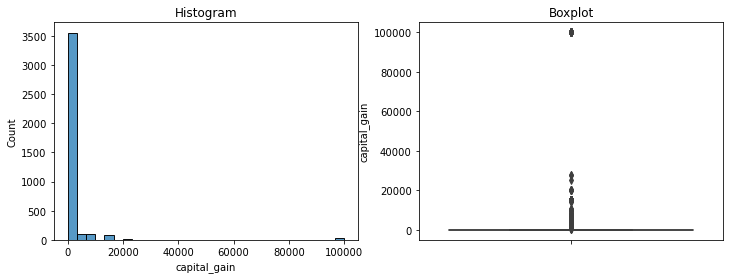

\capital_gain - After Capping


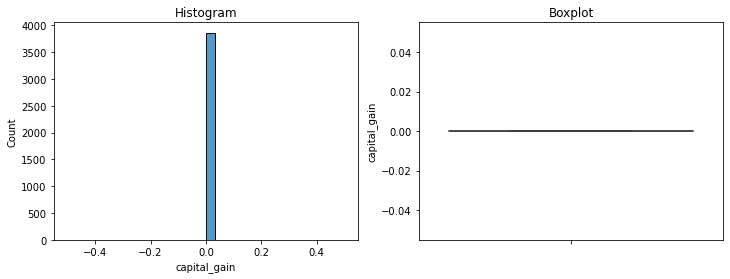

capital_loss - Before Capping


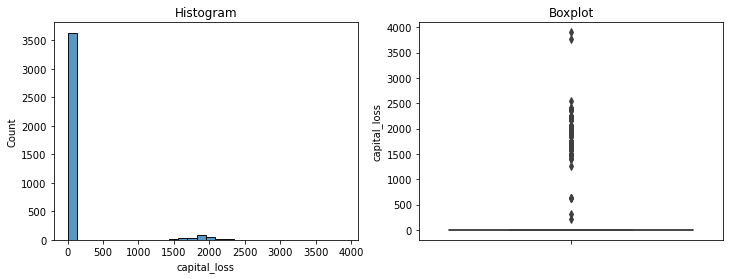

\capital_loss - After Capping


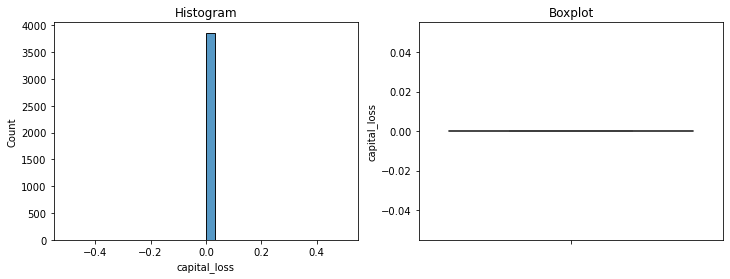

hours_per_week - Before Capping


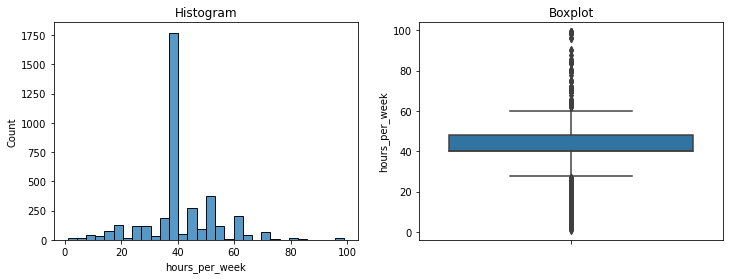

\hours_per_week - After Capping


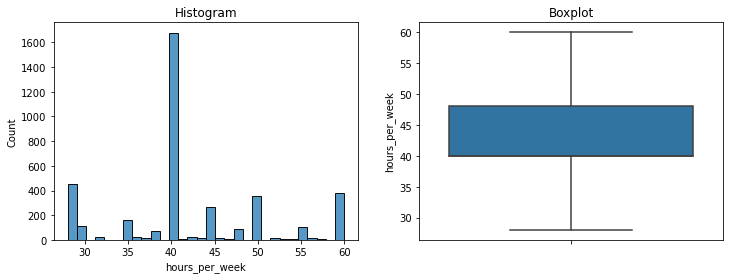

In [29]:
print('capital_gain - Before Capping')
diagnostic_plots(X_test, 'capital_gain')
print('\capital_gain - After Capping')
diagnostic_plots(X_test_t, 'capital_gain')

print('capital_loss - Before Capping')
diagnostic_plots(X_test, 'capital_loss')
print('\capital_loss - After Capping')
diagnostic_plots(X_test_t, 'capital_loss')

print('hours_per_week - Before Capping')
diagnostic_plots(X_test, 'hours_per_week')
print('\hours_per_week - After Capping')
diagnostic_plots(X_test_t, 'hours_per_week')


**HANDLING MISSING VALUE**

>X_train

In [30]:
mv_xtrain = pd.DataFrame(X_train.isnull().sum(), columns=['No. of missing values'])
mv_xtrain['% missing_values'] = (mv_xtrain/len(X_train)).round(2)*100
mv_xtrain

,No. of missing values,% missing_values
age,0,0.0
workclass,0,0.0
education,0,0.0
education_num,0,0.0
marital_status,0,0.0
occupation,0,0.0
relationship,0,0.0
race,0,0.0
sex,0,0.0
capital_gain,0,0.0


>>Terlihat bahwa X_train telah bersih dari adanya missing value

>X_Test

In [31]:
mv_xtest = pd.DataFrame(X_test.isnull().sum(), columns=['No. of missing values'])
mv_xtest['% missing_values'] = (mv_xtest/len(X_test)).round(2)*100
mv_xtest

,No. of missing values,% missing_values
age,0,0.0
workclass,0,0.0
education,0,0.0
education_num,0,0.0
marital_status,0,0.0
occupation,0,0.0
relationship,0,0.0
race,0,0.0
sex,0,0.0
capital_gain,0,0.0


>>Terlihat bahwa X_test telah bersih dari adanya missing value

**FEATURE SELECTION**

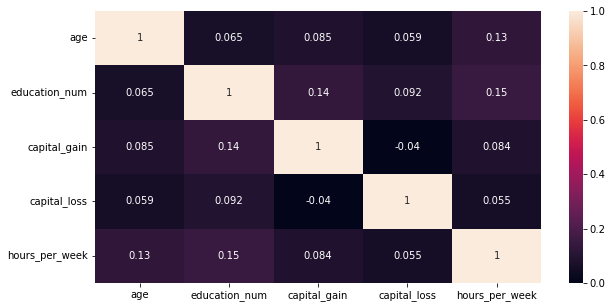

In [32]:
korelasi = data.corr()
plt.figure(figsize=(10,5))
sns.heatmap(korelasi, annot=True, vmin=0, vmax=1)
plt.show()

Setalah melakukan eksplorasi terhadap data, saya menemukan bahwa kolom `education` dan `education_num` tergolong sama, 9th selalu berpasangan dengan 5, 10th berpasangan dengan 6 dan seterusnya. Sehingga saya memutuskan untuk menghapus salah satu kolom yaitu kolom `education`

In [33]:
X_train.drop('education', axis=1, inplace=True)
X_test.drop('education', axis=1, inplace=True)

> Split kolom numeric dan kolom kategorik berdasarkan X_train

In [34]:
num_columns = X_train.select_dtypes(include=np.number).columns.tolist()
cat_columns = X_train.select_dtypes(include=['object']).columns.tolist()

print('Numerical Columns : ', num_columns)
print('Categorical Columns : ', cat_columns)

Numerical Columns :  ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
Categorical Columns :  ['workclass', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']


**FEATURE SCALING**

>**Cek Distribusi Data**

In [35]:
X_train.skew()      # Cek distribusi data

C:\Users\ASUS\AppData\Local\Temp/ipykernel_39472/365950309.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  X_train.skew()      # Cek distribusi data


age                0.434364
education_num     -0.294120
capital_gain      10.220377
capital_loss       4.018110
hours_per_week     0.338865
dtype: float64

>Split Train-set dan Test-set berdasarkan tipe kolom

In [36]:
num_column_min_max = ['capital_gain', 'capital_loss']           # Data yang skew
num_column_nor = ['age', 'education_num', 'hours_per_week']     # Data yang normal

X_train_skiw = X_train[num_column_min_max]                      # X_train_skew ialah nilai X_train yang datanya skew
X_test_skiw = X_test[num_column_min_max]                        # X__test_skew ialah nilai X_test yang datanya skew

X_train_nor = X_train[num_column_nor]                           # X_train_nor ialah nilai X_train yang datanya normal
X_test_nor = X_test[num_column_nor]                             # X_test_nor ialah nilai X_test yang datanya normal

In [37]:
skew = X_train_skiw.skew()  # Memeriksa kembali apakah telah sesuai pembagian data skew ataukan belum
skew

capital_gain    10.220377
capital_loss     4.018110
dtype: float64

In [38]:
skew2 = X_train_nor.skew()  # Memeriksa kembali apakah telah sesuai pembagian data normal ataukan belum
skew2

age               0.434364
education_num    -0.294120
hours_per_week    0.338865
dtype: float64

Terlihat bahwa :
- kolom `age` berdistribusi `normal`
- kolom `education_num` berdistribusi `normal`
- kolom `capital_gain` berdistribusi `skew`
- kolom `capital_loss` berdistribusi `skew`
- kolom `hours_per_week` berdistribusi `normal`

In [39]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler  # ada 3 jenis (MinMaxScaler, StandarScaler,Robust)

scaler = MinMaxScaler()          # Dipakai untuk data yang skew
scaler2 = StandardScaler()       # Dipakai untuk data yang normal

scaler.fit(X_train_skiw)         # .fit hanyalah milik X_train (matriks,vector)
scaler2.fit(X_train_nor)         # .fit hanyalah milik X_train (matriks,vector)   


X_train__num_Minmax = scaler.transform(X_train_skiw)    # Melakukan trasnfrom X_train_skiw
X_test_num_Minmax = scaler.transform(X_test_skiw)       # Melakukan transfrom X_test_skew

X_train_num_nor = scaler2.transform(X_train_nor)        # Melakukan transfrom X_train_nor
X_test_num_nor = scaler2.transform(X_test_nor)          # Melakukan transfrom X_test_nor


**FEATURE ENCODING**

In [40]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

encoder.fit(y_train)
y_train_encod = encoder.transform(y_train)
y_test_encod = encoder.transform(y_test)

>> Melakukan labeling terhadap target (y_train)

In [41]:
X_train_cat = X_train[cat_columns]      # Data X_train yang categorical
X_test_cat = X_test[cat_columns]        # Data X_test yang categorical

In [42]:
from sklearn.preprocessing import OrdinalEncoder

encoder2 = OrdinalEncoder()

encoder2.fit(X_train_cat)    # .fit hanyalah milik X_train

X_train_cat_encoded = encoder2.transform(X_train_cat)       # Melakukan transfrom terhadap X_train_cat
X_test_cat_encoded = encoder2.transform(X_test_cat)         # Melakukan transfrom terhdapa X_test_cat


**MERGE**

In [43]:
X_train_final = np.concatenate([X_train__num_Minmax, X_train_num_nor , X_train_cat_encoded], axis=1)

X_test_final = np.concatenate([X_test_num_Minmax, X_test_num_nor, X_test_cat_encoded], axis=1)

# **6. MODEL DEFINITION**

## Logistic Regression

In [44]:
log_reg = LogisticRegression()

## SVM

In [45]:
svm = SVC(kernel='linear', C=5)

# **7. MODEL TRAINING**

## Logistic Regression

In [46]:
log_reg.fit(X_train_final, y_train_encod)

c:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## SVM

In [47]:
svm.fit(X_train_final, y_train_encod)

SVC(C=5, kernel='linear')

# **8. MODEL EVALUATION**

## Logistic Regression

In [48]:
y_prediksi_log = log_reg.predict(X_test_final)

In [49]:
print(confusion_matrix(y_prediksi_log, y_test_encod))

[[2351  577]
 [ 282  651]]


In [50]:
print(classification_report(y_test_encod, y_prediksi_log))

              precision    recall  f1-score   support

           0       0.80      0.89      0.85      2633
           1       0.70      0.53      0.60      1228

    accuracy                           0.78      3861
   macro avg       0.75      0.71      0.72      3861
weighted avg       0.77      0.78      0.77      3861



Berdasarkan clasifikasi report diperoleh :
- F1-score untuk kelas 0 (<=50) sebesar 85% untuk kelas 1 (>50) sebesar 60%
- Recall untuk kelas 0 (<=50) sebesar 89% untuk kelas 1 (>50) sebesar 53%
- Presisi untuk kelas 0 (<=50) sebesar 80% untuk kelas 1 (>50) sebesar 70%

In [51]:
print(accuracy_score(y_prediksi_log, y_test_encod))
print(recall_score(y_prediksi_log, y_test_encod))

0.7775187775187775
0.6977491961414791


- Diperoleh akurasi model sebesar 77% dan recall sebesar 69%

## SVM

In [52]:
y_prediksi_svm = svm.predict(X_test_final)

In [53]:
print(confusion_matrix(y_prediksi_svm, y_test_encod))

[[2433  605]
 [ 200  623]]


Berdasarkan convusion matrix diperoleh bahwa :
- Kelas 0 (<=50) pada data set terprediksi benar sebanyak 2433 dan salah sebanyak 605
- Kelas 1 (>50) pada data set terprediksi benar sebanyak 623 dan salah sebanyak 200

In [54]:
print(classification_report(y_test_encod, y_prediksi_svm))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86      2633
           1       0.76      0.51      0.61      1228

    accuracy                           0.79      3861
   macro avg       0.78      0.72      0.73      3861
weighted avg       0.79      0.79      0.78      3861



Berdasarkan klasifikasi report diperoleh
- Presisi kelas 0 ialah 80% dan kelas 1 ialah 76%
- recall kelas 0 ialah 92% dan kelas 1 ialah 51%
- f-1 score kelas 0 ialah 86% dan kelas 1 ialah 61%

**MODEL SAVING**

In [55]:
with open('model_MinMaxScaler.pkl', 'wb') as file_1:      # 'wb' = write binary
    pickle.dump(scaler, file_1)

with open('model_StandarScaler.pkl', 'wb') as file_2:
    pickle.dump(scaler2, file_2)

with open('label_encoder.pkl', 'wb') as file_3:
    pickle.dump(encoder, file_3)

with open('ordinal_encoder.pkl', 'wb') as file_4:
    pickle.dump(encoder2, file_4)

with open('log_reg.pkl', 'wb') as file_5:
    pickle.dump(log_reg, file_5)

with open('svm.pkl', 'wb') as file_6:
    pickle.dump(svm, file_6)


with open('list_num_columns.txt', 'w') as file_7:
    file_7.write(str(num_columns))

with open('list_cat_columns.txt', 'w') as file_8:
    file_8.write(str(cat_columns))

# **9. MODEL INFERENCE**

**LOAD ALL MODEL**

In [56]:
with open('model_MinMaxScaler.pkl', 'rb') as file_1:      # 'rb' = ride binary    
    model_MinMax = pickle.load(file_1)

with open('model_StandarScaler.pkl', 'rb') as file_2:
    model_Stdscaler = pickle.load(file_2)

with open('label_encoder.pkl', 'rb') as file_3:
    model_Labencod = pickle.load(file_3)

with open('ordinal_encoder.pkl', 'rb') as file_4:
    model_Ordinalencoder = pickle.load(file_4)

with open('log_reg.pkl', 'rb') as file_5:
    model_logreg = pickle.load(file_5)

with open('svm.pkl', 'rb') as file_6:
    model_svm = pickle.load(file_6)


    
with open('list_num_columns.txt', 'r') as file_7:
    list_num_columns = file_7.read()

with open('list_cat_columns.txt', 'r') as file_8:
    list_cat_columns = file_8.read()

**Convert kolom numerik dan kategorik**

In [57]:
list_num_columns = ast.literal_eval(list_num_columns)
list_cat_columns = ast.literal_eval(list_cat_columns)

In [58]:
num_skew = ['capital_gain', 'capital_loss']
num_normal = ['age', 'education_num','hours_per_week']

**Split Kolom Numerik dan Categorik**

In [59]:
data_inf_num_nor = data_inf[num_normal]
data_inf_num_skew = data_inf[num_skew]

data_inf_cat = data_inf[list_cat_columns]


**Feature Scaling dan Feature Encoding**

In [60]:
data_inf_num_scaled = model_MinMax.transform(data_inf_num_skew)

data_inf_cat_encoded = model_Stdscaler.transform(data_inf_num_nor)

data_inf_Ordinalencoder = model_Ordinalencoder.transform(data_inf_cat)

**Concate**

In [61]:
data_inf_final = np.concatenate([data_inf_num_scaled, data_inf_cat_encoded, data_inf_Ordinalencoder], axis=1)
data_inf_final


array([[ 0.        ,  0.        , -0.42221163, -0.42875294, -0.10352845,
         3.        ,  2.        ,  1.        ,  0.        ,  4.        ,
         1.        , 38.        ],
       [ 0.        ,  0.44615385, -0.72917371,  1.08981755,  0.29412844,
         3.        ,  2.        , 10.        ,  0.        ,  4.        ,
         1.        , 38.        ],
       [ 0.1502415 ,  0.        ,  0.34519357,  1.08981755,  1.08944223,
         3.        ,  2.        , 14.        ,  0.        ,  4.        ,
         1.        , 38.        ],
       [ 0.        ,  0.        ,  0.26845305, -0.04911032, -0.10352845,
         3.        ,  2.        ,  3.        ,  0.        ,  4.        ,
         1.        , 38.        ],
       [ 0.        ,  0.        , -1.34309787, -0.04911032, -2.48946979,
         3.        ,  4.        , 10.        ,  2.        ,  4.        ,
         0.        , 38.        ],
       [ 0.        ,  0.        , -1.41983838, -0.04911032, -1.69415601,
         3.        ,  

## **EVALUASI MODEL**

## Logistic Regression

In [62]:
y_inf_pred = model_logreg.predict(data_inf_final)
y_inf_pred

array([0, 1, 1, 0, 0, 0, 0, 1, 1, 1])

In [63]:
y_pred_inf_df = pd.DataFrame(y_inf_pred, columns=['income_bracket - Prediction'])
y_pred_inf_df

,income_bracket - Prediction
0,0
1,1
2,1
3,0
4,0
5,0
6,0
7,1
8,1
9,1


**Merge**

In [64]:
pd.concat([data_inf, y_pred_inf_df], axis=1)

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket,income_bracket - Prediction
0,34,Private,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States,<=50K,0
1,30,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,1740,45,United-States,<=50K,1
2,44,Private,Bachelors,13,Married-civ-spouse,Transport-moving,Husband,White,Male,15024,0,55,United-States,>50K,1
3,43,Private,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>50K,0
4,22,Private,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,10,United-States,<=50K,0
5,21,Private,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K,0
6,46,Private,Assoc-acdm,12,Widowed,Prof-specialty,Unmarried,White,Female,0,0,27,United-States,<=50K,0
7,44,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,1902,50,United-States,>50K,1
8,53,Private,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1977,55,United-States,>50K,1
9,48,Private,Bachelors,13,Divorced,Sales,Unmarried,White,Female,0,0,44,United-States,<=50K,1


In [65]:
intercept = model_logreg.intercept_
slope = model_logreg.coef_

print('Intercept : ', intercept)
print('Slope : ', slope)

Intercept :  [-1.34389561]
Slope :  [[ 9.06027975  3.45592115  0.50590352  0.91247222  0.2842742  -0.11247423
  -0.22632576  0.00908004 -0.17545863  0.09658557  0.45384989  0.01246445]]


## SVM

In [66]:
y_inf_pred1 = model_svm.predict(data_inf_final)
y_inf_pred1

array([0, 1, 1, 0, 0, 0, 0, 1, 1, 0])

In [67]:
y_pred_inf_df2 = pd.DataFrame(y_inf_pred1, columns=['income_bracket - Prediction'])
y_pred_inf_df2

,income_bracket - Prediction
0,0
1,1
2,1
3,0
4,0
5,0
6,0
7,1
8,1
9,0


In [68]:
pd.concat([data_inf, y_pred_inf_df2], axis=1)

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket,income_bracket - Prediction
0,34,Private,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States,<=50K,0
1,30,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,1740,45,United-States,<=50K,1
2,44,Private,Bachelors,13,Married-civ-spouse,Transport-moving,Husband,White,Male,15024,0,55,United-States,>50K,1
3,43,Private,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>50K,0
4,22,Private,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,10,United-States,<=50K,0
5,21,Private,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K,0
6,46,Private,Assoc-acdm,12,Widowed,Prof-specialty,Unmarried,White,Female,0,0,27,United-States,<=50K,0
7,44,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,1902,50,United-States,>50K,1
8,53,Private,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1977,55,United-States,>50K,1
9,48,Private,Bachelors,13,Divorced,Sales,Unmarried,White,Female,0,0,44,United-States,<=50K,0


In [69]:
intercept = model_svm.intercept_
slope = model_svm.coef_

print('Intercept : ', intercept)
print('Slope : ', slope)

Intercept :  [-0.85735813]
Slope :  [[ 2.24698927e+01  2.45560334e+00  2.40230938e-01  6.78526054e-01
   2.00664266e-01 -6.64507706e-02 -1.16123627e-01 -2.81839904e-03
  -1.61994022e-01  5.36784624e-02  1.49764443e-01  5.06103941e-03]]


----

# **10. KESIMPULAN**

## **EXPLORATORY DATA ANALYSIS (EDA)**

- Terdapay imbalance yang cukup besar berdasarkan kolom `income_bracker`, terlihat bahwa golongan pendapatan kurang dari `50K` lebih banyak dibandingkan yang memiliki pendapatan lebih dari `50K`.
- Berdasatkan rentang usia terlihat bahwa : 

- Seseorang yang mendapatkan `income bracket >50K terbanyak pada usia 46 tahun`
- Seseorang yang mendapatkan `income bracket <50K terbanyak terletak pada usia 23 tahun`
- Seseorang yang memiliki usia `21 tahun kebawah tidak memiliki income_bracket >50K`

- Berdasarkan status pernikahan, terlihat yang memiliki status telah menikah lebih banyak memiliki `income bracket <=50K dan juga >50K` dibandingkan dengan status yang lain.

- Berdasarkan pekerjaan, terlihat bahwa `Armed_forces` adalah pekerjaan dengan proporsi paling rendah berdasarkan `income_bracket` dibandingkan dengan jenis pekerjaan yang lain.

- Berdasarkan relationship, terlihat bahwa `husband(suami)` memiliki pendapatan yang lebih banyak dibandingkan hubungan yang lian

- Berdasarkan gender terlihat bahwa `pria` memiliki pendapatan lebih banyak pendapatan dibandingkan `wanita`. grafik ini mendukung pendapat kita sebelumnya dimana suami memiliki pendapatan yang lebih dibandingkan istri

----

## **LOGISTIC REGRESSION**

> Hasil confussion matrix

> - Prediksi `<=50` pada data set terlihat terprediksi benar sebanyak 2356 dan terprediksi salah 277
> - Prediksi `>50` pada data set terlihat terprediksi benar sebanyak 634 dan terprediksi salah 594

> Evaluasi model regresi dihasilkan

classificasi report diatas telah diperoleh :
>- Hasil akurasi antara y_test_cat_encoded dengan y_pred_test ialah 0.77 atau 77%

>- Hasil prediksi income_bracker <=50K bernilai benar ialah 0.84 atau 84%

>- Hasil prediksi income_bracker >50K bernilai benar ialah 0.84 atau 84%

Persamaan linear menggunakan logistik regressi

`y` = -1.34389561 + 9.06027975 age +  3.45592115 workclass + 0.50590352 education_num + 0.91247222 marital_status +  0.2842742 occupation - 0.11247423 relationship - 0.22632576 race + 0.00908004 sex - 0.17545863 capital_gain +
0.09658557 capital_lose + 0.45384989 hours_per_week + 0.01246445 native_country

## **SVM**

> Berdasarkan convusion matrix diperoleh bahwa :
- Kelas 0 (<=50) pada data set terprediksi benar sebanyak 2433 dan salah sebanyak 605
- Kelas 1 (>50) pada data set terprediksi benar sebanyak 623 dan salah sebanyak 200

> Berdasarkan klasifikasi report diperoleh
- Presisi kelas 0 ialah 80% dan kelas 1 ialah 76%
- recall kelas 0 ialah 92% dan kelas 1 ialah 51%
- f-1 score kelas 0 ialah 86% dan kelas 1 ialah 61%

> Intercept :  [-0.85735813]

> Slope :  [[ 2.24698927e+01  2.45560334e+00  2.40230938e-01  6.78526054e-01
   2.00664266e-01 -6.64507706e-02 -1.16123627e-01 -2.81839904e-03
  -1.61994022e-01  5.36784624e-02  1.49764443e-01  5.06103941e-03]]

> Persamaan linear menggunakan SVM

`y` =  -0.85735813 + 2.24698927e+01 age +  2.45560334e+00 workclass +  2.40230938e-01 education_num +  6.78526054e-01 marital_status + 2.00664266e-01 occupation - 6.64507706e-02 relationship - 1.16123627e-01 race - 2.81839904e-03 sex + 1.61994022e-01 capital_gain + 5.36784624e-02 capital_loss + 1.49764443e-01 hours_per_week + 5.06103941e-03 native_country

----

**CONCEPTUAL PROBLEM** 

Jawab pertanyaan berikut:
1. Apakah yang dimaksud dengan coeficient pada logistic regression?
2. Apakah yang dimaksud dengan Support Vector pada SVM?
3. Apakah fungsi parameter kernel pada SVM? Jelaskan salah satu kernel yang kalian pahami!

Answere

1. Coeficient pada logistic regresi menyatakan hubungan searah atau berbalik arah antara variabel independent dan variabel dependent. Jika positif maka hubunganya searah dan jika negatif maka hubungannya berbalik arah

2. Margin diperoleh berdasarkan jarak terdekat antara decission bundary (garis pemisah) dengan anggota class yang ingin dipisahkan. Setiap anggota class yang berperan untuk menentukan margin dikenal sebagai `support vector`

3. Kernel berfungsi untuk memproyeksikan data ke dimensi yang lebih tinggi. Adapun jenis-jenis kernel ialah polinomial, sigmoid, Radial Bias Function (RBF) dll. Kernel RBF adalah kernel default yang digunakan dalam algoritme klasifikasi SVM serta memiliki kemiripan dengan distribusi Gaussian. Adapun fungsi kernel RBF untuk dua titik X1 dan X2 ialah menghitung kesamaan atau seberapa dekat keduanya. Kernel RBF memiliki nilai maksimum ialah 1 dan terjadi jika nilai X1 = X2.Adapun kernel RBF menggunakan kurva normal di sekitar titik data dan menjumlahkanya sehingga keputusanya ditentukan dari jenis topologi kurva.  